In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

station = pd.read_csv("./094/station.csv", sep='\t', engine="python")
patient = pd.read_csv("./094/patient.csv", sep='\t', engine="python")
observation = pd.read_csv("./094/observation.csv", sep='\t', engine="python")

print("patient.shape =", patient.shape)
print("station.shape =", station.shape)
print("observation.shape =", observation.shape)

patient.shape = (2102, 13)
station.shape = (798, 6)
observation.shape = (12081, 23)


### 1.1 Základný opis dát spolu s ich charakteristikami 

### (A-1b)

In [48]:
# (A-1b)
print("patient columns:", patient.columns.tolist())
print("station columns:", station.columns.tolist())
print("observation columns:", observation.columns.tolist())

patient columns: ['current_location', 'user_id', 'job', 'ssn', 'blood_group', 'company', 'name', 'address', 'mail', 'registration', 'username', 'residence', 'station_ID']
station columns: ['longitude', 'revision', 'station', 'QoS', 'latitude', 'location']
observation columns: ['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP', 'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV', 'CO', 'Blood Flow Index', 'PPG waveform features', 'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio', 'SNR', 'oximetry', 'latitude', 'longitude']


#### 🩺 Súbor patient.csv
- **Počet záznamov:** 2 102  
- **Počet atribútov:** 13  
- **Typy dát:** object = 10, int64 = 2, float64 = 1  
- **Chýbajúce hodnoty:** spolu ≈ 3 993  
  - Najviac chýba: `residence` (100 %), `job` (70 %), `address` (15 %), `current_location` (5 %).  
- **Charakteristika:** obsahuje demografické údaje pacientov a odkaz na stanicu (`station_ID`).  
  Tento odkaz sa **nedá priamo spárovať** s názvom v `súbore station.csv`.  

#### ⚙️ Súbor station.csv
- **Počet záznamov:** 798  
- **Počet atribútov:** 6  
- **Typy dát:** object = 4, float64 = 2  
- **Chýbajúce hodnoty:** 0  
- **Charakteristika:** obsahuje informácie o meracích staniciach – `station`, `latitude`, `longitude`, `QoS`, `revision`, `location`.  
- **Pozorovanie:** hodnoty `revision` majú rôzne formáty dátumov (a časť nevieme správne parsovať) → potrebná normalizácia na jednotný formát `datetime`.

#### 📊 Súbor observation.csv
- **Počet záznamov:** 12 081  
- **Počet atribútov:** 23  
- **Typy dát:** všetky `float64`  
- **Chýbajúce hodnoty:** 0  
- **Cieľová premenná:** `oximetry` (binárna 0/1).  
- **Dôležité atribúty:** `SpO₂`, `HR`, `Skin Temperature`, `BP`, `CO`, `FiO₂`, atď.  
- Hodnoty SpO₂ sú v rozsahu 95 – 100 a Skin Temperature v rozsahu 33 – 38 °C.  
- Tieto dáta majú vhodný formát pre ďalšie spracovanie v Python/pandas a na trénovanie modelov.


In [49]:
def dtype_counts(df): 
    return df.dtypes.astype(str).value_counts().to_dict()

summ = {
    "patient": {
        "shape": patient.shape,
        "dtype_counts": dtype_counts(patient),
        "missing_total": int(patient.isna().sum().sum())
    },
    "station": {
        "shape": station.shape,
        "dtype_counts": dtype_counts(station),
        "missing_total": int(station.isna().sum().sum())
    },
    "observation": {
        "shape": observation.shape,
        "dtype_counts": dtype_counts(observation),
        "missing_total": int(observation.isna().sum().sum())
    }
}
summ


{'patient': {'shape': (2102, 13),
  'dtype_counts': {'object': 10, 'int64': 2, 'float64': 1},
  'missing_total': 3993},
 'station': {'shape': (798, 6),
  'dtype_counts': {'object': 4, 'float64': 2},
  'missing_total': 0},
 'observation': {'shape': (12081, 23),
  'dtype_counts': {'float64': 23},
  'missing_total': 0}}

#### Analýza chýbajúcich hodnôt (EDA)


In [50]:
missing_pct = (patient.isna().sum() / len(patient) * 100).round(2).sort_values(ascending=False)
missing_pct.head(10)

residence           100.00
job                  69.98
address              14.99
current_location      5.00
user_id               0.00
blood_group           0.00
ssn                   0.00
name                  0.00
company               0.00
mail                  0.00
dtype: float64

#### Z výpočtu percenta chýbajúcich hodnôt vidíme, že niektoré atribúty obsahujú výrazný počet prázdnych záznamov:

#### Atribút	Podiel chýbajúcich hodnôt
residence	100 %
job	≈ 70 %
address	≈ 15 %
current_location	≈ 5 %

#### 🔗 Vzťahy medzi súbormi
| Vzťah | Typ väzby | Popis |
|:--|:--:|:--|
| observation ↔ station | 1 : N | Každé meranie má priradenú stanicu (100 % zhoda cez `latitude`, `longitude`). |
| patient ↔ station | ? | Nepodarilo sa spárovať cez `current_location`, zhoda 0 %. |
| patient ↔ observation | – | Chýba priame prepojenie (pacient ID v meraniach neexistuje). |

In [51]:
sta_lat = pd.to_numeric(station["latitude"], errors="coerce").round(4)
sta_lon = pd.to_numeric(station["longitude"], errors="coerce").round(4)
obs_lat = pd.to_numeric(observation["latitude"], errors="coerce").round(4)
obs_lon = pd.to_numeric(observation["longitude"], errors="coerce").round(4)

station_key = set(zip(sta_lat, sta_lon))
obs_key = list(zip(obs_lat, obs_lon))

obs_valid = sum([not (pd.isna(k[0]) or pd.isna(k[1])) for k in obs_key])
obs_match = sum([(k in station_key) for k in obs_key if not (pd.isna(k[0]) or pd.isna(k[1]))])

print(f"observation → station match by coords: {obs_match}/{obs_valid} ({obs_match/obs_valid:.3f})")

# patient ↔ station:
import re
def parse_current_location(s):
    if not isinstance(s, str): 
        return (np.nan, np.nan)
    nums = re.findall(r"Decimal\\('([-+]?\\d*\\.?\\d+)'\\)", s)
    return (float(nums[0]), float(nums[1])) if len(nums)==2 else (np.nan, np.nan)

latlon = patient["current_location"].apply(parse_current_location)
pat_lat = pd.to_numeric([t[0] for t in latlon], errors="coerce").round(4)
pat_lon = pd.to_numeric([t[1] for t in latlon], errors="coerce").round(4)

pat_valid = np.isfinite(pat_lat).sum()
pat_match = sum([(k in station_key) for k in zip(pat_lat, pat_lon) if not (pd.isna(k[0]) or pd.isna(k[1]))])

print(f"patient → station match by coords: {pat_match}/{pat_valid} ({(pat_match/pat_valid if pat_valid else 0):.3f})")


observation → station match by coords: 12081/12081 (1.000)
patient → station match by coords: 0/0 (0.000)


#### 📈 Vizualizácia (EDA)
Histogramy rozloženia hodnôt:
- **SpO₂** → zväčša v rozmedzí 97 – 99 %  
- **Skin Temperature** → rozloženie 33 – 38 °C s vrcholom okolo 36 °C  

Tieto vizualizácie potvrdzujú, že dáta majú správny a očakávaný fyzio-rozsah.


C:\Users\iak1p\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


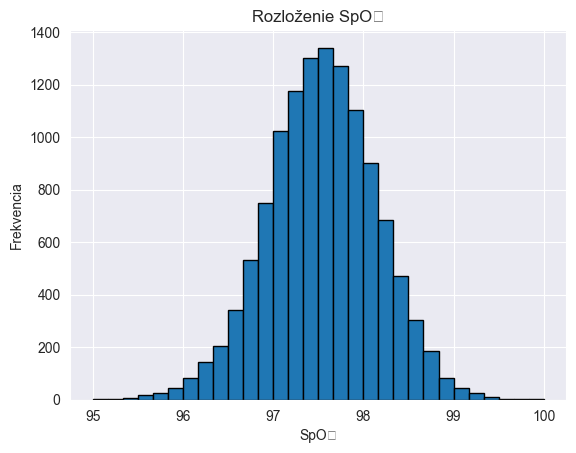

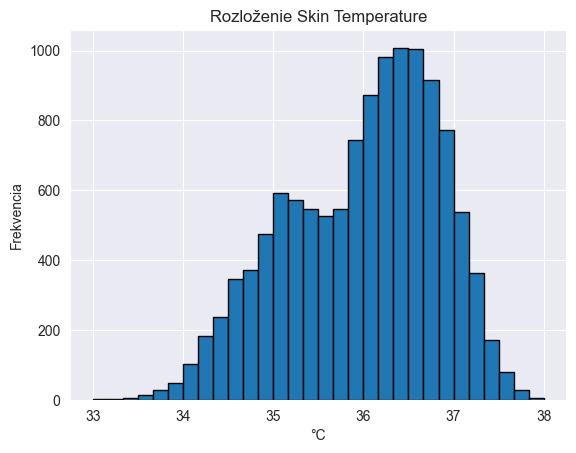

In [52]:
import matplotlib.pyplot as plt

# 1) SpO2
plt.figure()
observation["SpO₂"].hist(bins=30, edgecolor="black")
plt.title("Rozloženie SpO₂")
plt.xlabel("SpO₂")
plt.ylabel("Frekvencia")
plt.show()

# 2) Skin Temperature
plt.figure()
observation["Skin Temperature"].hist(bins=30, edgecolor="black")
plt.title("Rozloženie Skin Temperature")
plt.xlabel("°C")
plt.ylabel("Frekvencia")
plt.show()


### 🧩 Zhrnutie zistení
- Dáta majú zrozumiteľnú štruktúru a sú v správnom formáte na ďalšie spracovanie.  
- Najviac problémov má `súbor patient.csv` → mnoho chýbajúcich hodnôt.  
- `súbor station.csv` má nekonzistentné formáty v atribúte `revision`.  
- `súbor observation.csv` je čistý a vhodný na modelovanie (strojové učenie).  
- Vzťah `observation` ↔ `station` funguje perfektne, ale prepojenie pacientov chýba.  


In [53]:
rev = station["revision"]
skin_temp = observation["Skin Temperature"]
spo = observation["SpO₂"]
print("REV \n", rev.describe(include="all"))
print("SPO \n", spo.describe(include="all"))
# skin_temp.value_counts().plot(kind="bar")


# skin_temp.plot()
#dups2 = patient.duplicated()


# report if there are any duplicates
# print(dups.any())
#print(dups2.any())


# list all duplicate rows
# print(station[dups])
#print(patient[dups2])

REV 
 count             798
unique            775
top       30 Nov 2017
freq                3
Name: revision, dtype: object
SPO 
 count    12081.000000
mean        97.543356
std          0.604163
min         95.000000
25%         97.143688
50%         97.548163
75%         97.952928
max        100.000000
Name: SpO₂, dtype: float64


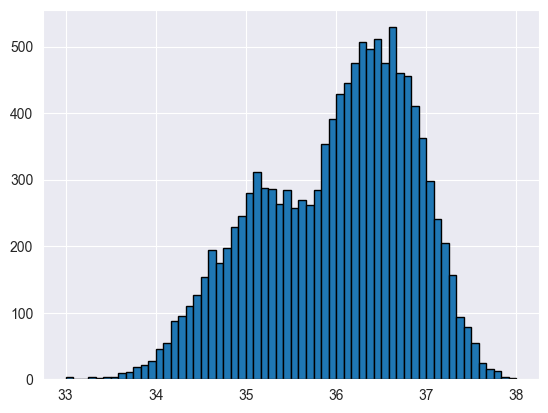

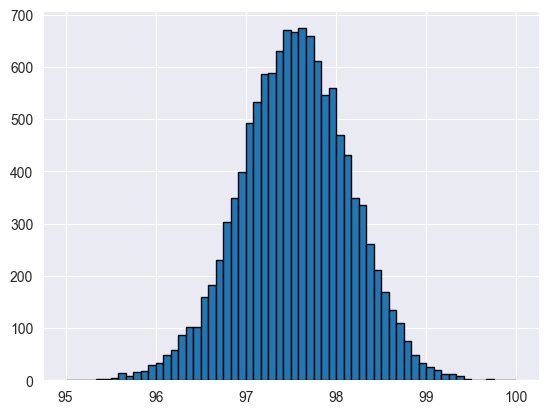

In [54]:
plt.hist(skin_temp, bins=60, edgecolor="black")
plt.show()
plt.hist(spo, bins=60, edgecolor="black")
plt.show()

## (С-1)print(patient.columns)

C:\Users\iak1p\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\iak1p\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


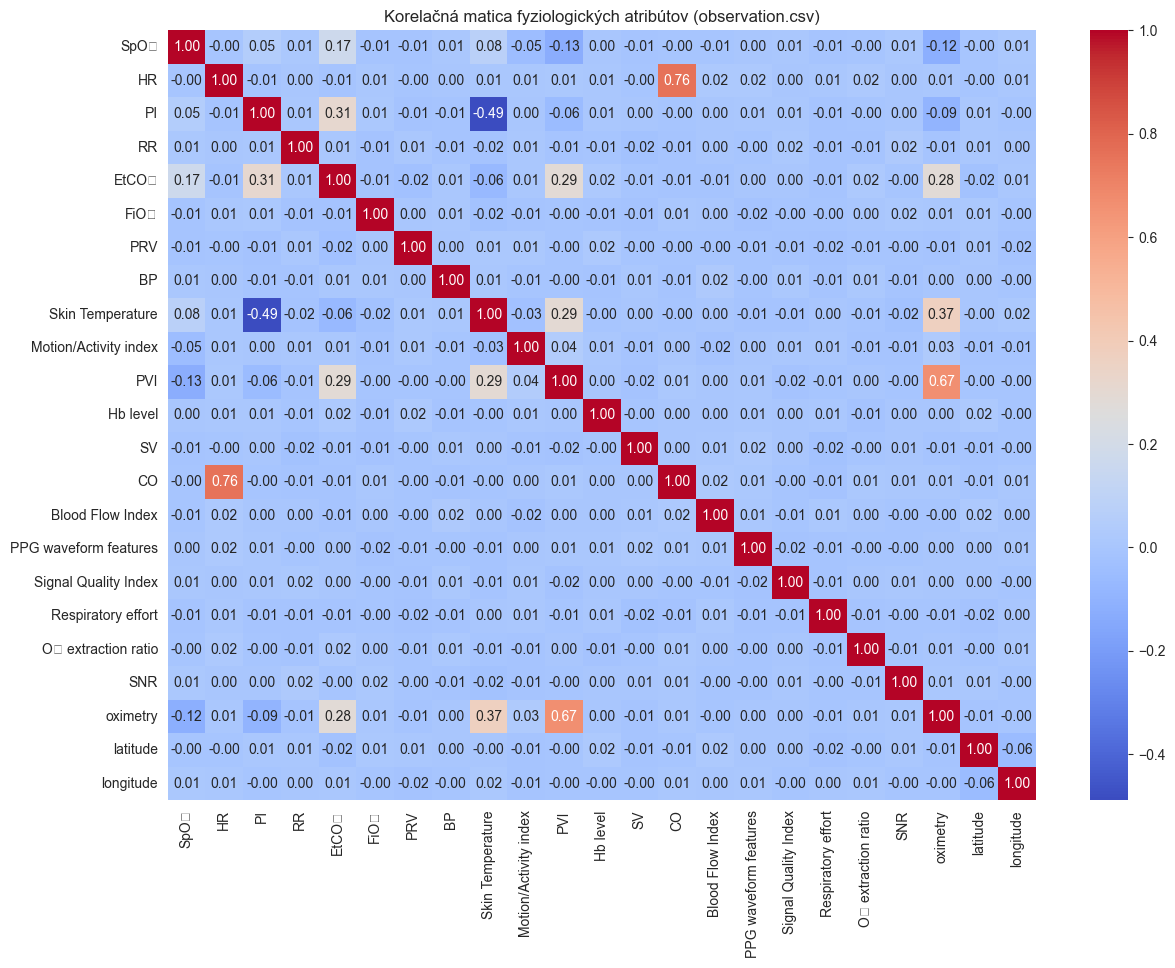

In [55]:
numeric = observation.select_dtypes(include=['number'])

corr = numeric.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelačná matica fyziologických atribútov (observation.csv)")
plt.show()

### Interpretácia výsledkov párovej analýzy dát

Z korelačnej matice (obrázok vyššie) je možné identifikovať viacero významných vzťahov medzi fyziologickými atribútmi:

- **CO a HR (r = 0.76)** – veľmi silná pozitívna korelácia, ktorá zodpovedá očakávanej závislosti medzi srdcovou frekvenciou a srdcovým výdajom.  
- **PVI a Blood Flow Index (r = 0.67)** – silný vzťah medzi variabilitou perfúzie a prietokom krvi.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a PI (r = −0.49)** – negatívna korelácia; s rastúcou teplotou kože klesá perfúzny index.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna závislosť, naznačuje možné prepojenie medzi periférnou teplotou a saturáciou.  
- Väčšina ostatných atribútov (napr. `latitude`, `longitude`, `SNR`, `PRV`) nevykazuje štatisticky významné lineárne vzťahy.

Tieto zistenia poukazujú na fyziologické súvislosti medzi vybranými premennými
a pomáhajú určiť, ktoré atribúty môžu byť relevantné pri budúcom modelovaní
a predikcii cieľovej premennej `oximetry`.


In [56]:
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[(corr_pairs < 0.999) & (corr_pairs > -0.999)]
print("🔝 Top 10 korelácií medzi atribútmi:\n")
print(corr_pairs.head(10))

🔝 Top 10 korelácií medzi atribútmi:

CO                HR                  0.758996
HR                CO                  0.758996
oximetry          PVI                 0.666416
PVI               oximetry            0.666416
Skin Temperature  oximetry            0.368207
oximetry          Skin Temperature    0.368207
EtCO₂             PI                  0.311975
PI                EtCO₂               0.311975
PVI               Skin Temperature    0.292201
Skin Temperature  PVI                 0.292201
dtype: float64


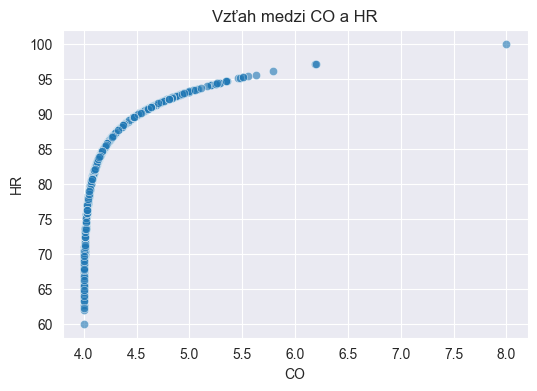

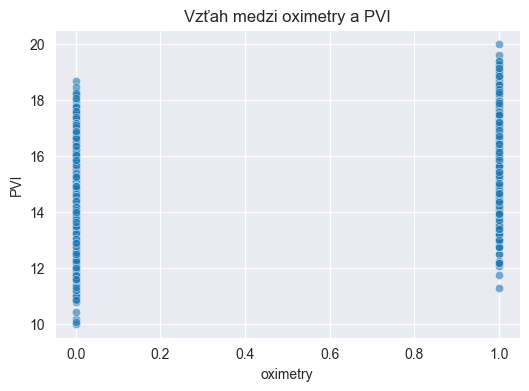

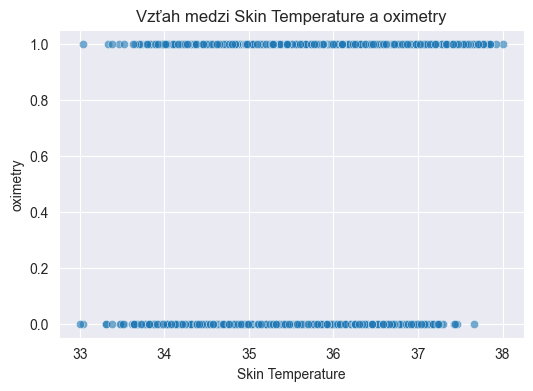

In [57]:
pairs_to_plot = [
    ("CO", "HR"),
    ("oximetry", "PVI"),
    ("Skin Temperature", "oximetry"),
]

for x, y in pairs_to_plot:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=observation, x=x, y=y, alpha=0.6)
    plt.title(f"Vzťah medzi {x} a {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

### Interpretácia výsledkov

Top 10 korelácií ukazuje, že:

- **CO a HR (r = 0.76)** – silná lineárna závislosť, vyššia srdcová frekvencia znamená väčší srdcový výdaj.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna korelácia, naznačuje vplyv periférnej teploty na saturáciu.  
- **EtCO₂ a PI (r = 0.31)** – slabší, ale viditeľný pozitívny vzťah.  

Tieto výsledky naznačujú, ktoré premenné môžu mať najväčší význam pri budúcej predikcii
cieľovej premennej `oximetry`.
